# Training Deep Neural Networks on GPU


linear model not able to capture non linear realationship
each pixel is independent of each other

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split

### Downloading dataset

In [179]:
dataset=MNIST(root="data/",download=True,transform=transforms.ToTensor())

In [180]:
len(dataset)

60000

In [181]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

5


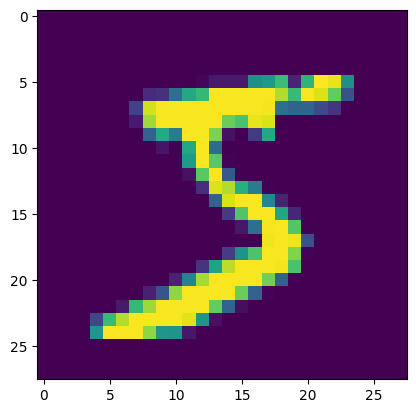

In [182]:
image,label =dataset[0]
plt.imshow(image.permute(1,2,0))
print(label)

In [183]:
train_ds,val_ds=random_split(dataset,[50000,10000])

In [184]:
print(len(train_ds))
print(len(val_ds))

50000
10000


In [185]:
#create dataloader
#we want to train our model using gradient descent while doing gradient descent we need to work with batches
batchsize=128
train_dl=DataLoader(train_ds,batch_size=batchsize,shuffle=True,num_workers=4,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=batchsize,num_workers=4,pin_memory=True)

num_workers specifies how many subprocesses will be used to load data in parallel, potentially speeding up data loading, especially for large datasets
Each worker process retrieves a batch of data from the dataset and sends it to the main training process. 

Pinned memory allows for faster data transfer to the GPU because the data can be transferred directly to the GPU without the need for intermediate copying from the CPU.


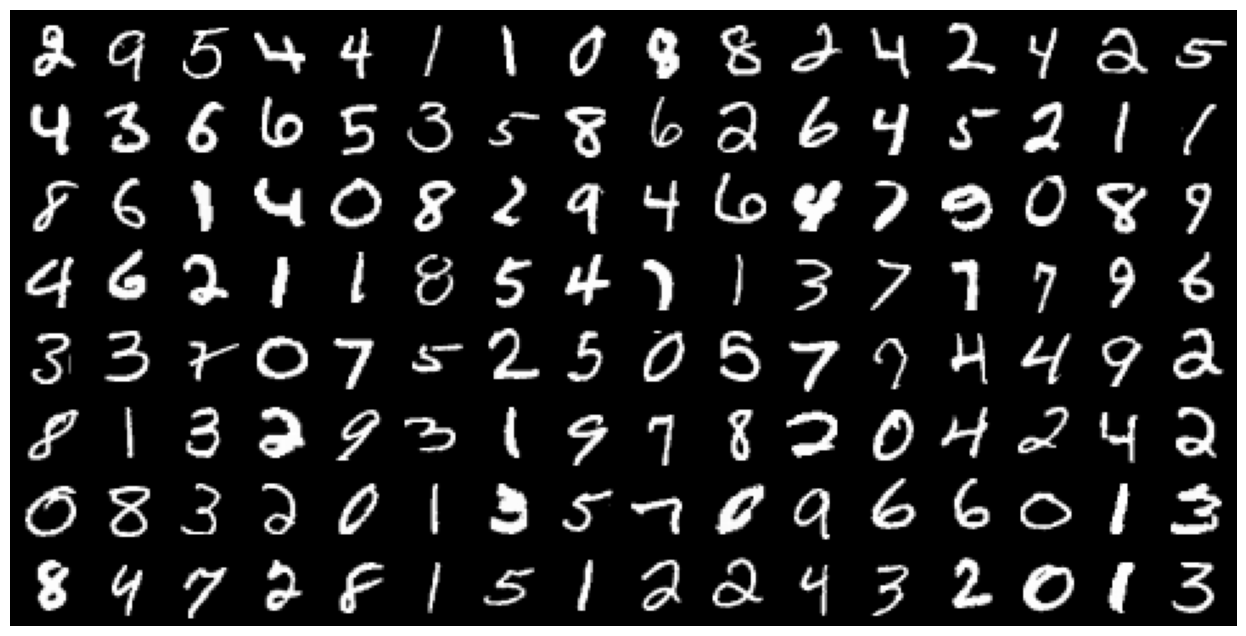

In [187]:
#visualizing data using make_grid
from torchvision.utils import make_grid
for images,labels in train_dl:
    plt.figure(figsize=(16,8))
    plt.axis("off")
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

### Model

In [189]:
for images,labels in train_dl:
    print(images.shape)
    inputs=images.reshape(-1,784)
    print(inputs.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [190]:
input_size=784
hidden_size=32
layer1=nn.Linear(input_size,hidden_size)


In [191]:
#layer1
output1=layer1(inputs)
output1.shape

torch.Size([128, 32])

In [192]:
output2=inputs@layer1.weight.t()+layer1.bias
output2.shape

torch.Size([128, 32])

In [193]:
torch.allclose(output1,output2,0.001)

True

In [194]:
#layer1 captures only linear relationships now introduce non linear activation function relu rectified linear unit
#relu(x)=max(0,x)


In [195]:
relu_outputs=F.relu(output1)

In [196]:
#layer2
output_size=10
layer2=nn.Linear(hidden_size,output_size)

In [197]:
layer2_outputs=layer2(relu_outputs)

In [198]:
layer2_outputs.shape

torch.Size([128, 10])

our model transforms inputs into layer2_outputs by applying a linear transformation using layer1  followed by a non linear activation fn ,followeed by another linear transformation

Introducing non linearity makes the model more powerful adn versatile
hidden_size can be increased and no of layers can be incresed to make model more powerful


Universal approximation theorem states that a sufficiently large &deep nural network can compute any arbitrary function

Deep learning models often contain millions of parameters which can together capture far more complex relationships than the human brain can comprehend
if we hadnt include a non linear activation between the two linear layers the final realationship between inputs and outputs would still be linear

In [203]:
#layer2(layer1(inputs))
output2=(inputs@layer1.weight.t()+layer1.bias)@layer2.weight.t()+layer2.bias


In [204]:
combined_layer=nn.Linear(input_size,output_size)
combined_layer.weight.data=layer2.weight@layer1.weight
combined_layer.bias.data=layer1.bias@layer2.weight.t()+layer2.bias

In [205]:
output3=combined_layer(inputs)

In [206]:
torch.allclose(output2,output3,1e-3)

True

In [207]:
class MNIST_model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.linear1=nn.Linear(input_size,hidden_size)
        self.linear2=nn.Linear(hidden_size,output_size)
    def forward(self,xb):
        xb=xb.view(xb.size(0),-1)
        out=self.linear1(xb)
        out=F.relu(out)
        out=self.linear2(out)
        return out
    def training_step(self,batch):
        images,labels=batch
        outputs=self(images)
        loss=F.cross_entropy(outputs,labels)
        return loss
    def validation_step(self,batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self,outputs):
        acc=[x["val_acc"] for x in outputs]
        loss=[x['val_loss'] for x in outputs]

        mean_acc=torch.stack(acc).mean()
        mean_loss=torch.stack(loss).mean()
        return {"val_loss":mean_loss.item(),"val_acc":mean_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


    

In [208]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))
#Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.

In [209]:
input_size=784
hidden_size=32
num_classes=10

In [210]:
model=MNIST_model(input_size,hidden_size,num_classes)


In [211]:
for images,labels in train_dl:
    output= model(images)
    print(output.shape)
    print(F.cross_entropy(output,labels))
    break



torch.Size([128, 10])
tensor(2.3114, grad_fn=<NllLossBackward0>)


### Using GPU

In [213]:
 torch.cuda.is_available() #cuda is the langugae to communicate with gpu


True

In [214]:
def get_default_device(): # return a pointer to gpu or cpu
    """pick gpu if available or else cpu"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [215]:
device=get_default_device()
device

device(type='cuda')

In [216]:
#move data and model to gpu
def to_device(data,device):
    if(isinstance(data,(list,tuple))):
        return [to_device(x,device) for x in data] #this is for list of tensors or tuple of tensors
        
    return data.to(device,non_blocking=True) #for tensors and model

In [217]:
for images,labels in train_dl:
    print(images.device)
    images=to_device(images,device)
    print(images.device)
    break

cpu
cuda:0


In [218]:
#we need to move each batch of data into gpu and process and leave gpu

In [219]:
#  devicedataloader  wrap dataloader to move data to device
class Device_Data_Loader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self): #to retrive batches
        for i in self.dl:
            yield to_device(i,self.device) #to cerate a generator function can be used within a for loop
    def __len__(self):
        return len(self.dl)

In [220]:
train_dl=Device_Data_Loader(train_dl,device)
val_dl=Device_Data_Loader(val_dl,device)

In [221]:
#when we try to iter on train_dl or val_dl batches automatically moved to device

In [222]:
for images,labels in train_dl:
    print(images.device)
    break

cuda:0


### Training the Model

In [265]:
#model and data should be present on eith er gpu or cpu

In [430]:
def fit(epochs,lr,model,train_dl,val_dl,opt_fn=torch.optim.SGD):
    opt_fn=opt_fn(model.parameters(),lr)
    history=[]
    #training phase
    for epoch in range(epochs):
        for batch in train_dl:
            loss=model.training_step(batch)
            loss.backward()
            opt_fn.step()
            opt_fn.zero_grad()
        #validation phase
        result=evaluate(model,val_dl)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [432]:
def evaluate(model,val_dl):
    outputs= [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

In [434]:
model=to_device(model,device)

In [436]:

hist=[evaluate(model,val_dl)]
print(hist)

[{'val_loss': 0.19914478063583374, 'val_acc': 0.9433346390724182}]


In [437]:
hist+=fit(5,0.1,model,train_dl,val_dl)

Epoch [0], val_loss: 0.1901, val_acc: 0.9450
Epoch [1], val_loss: 0.1824, val_acc: 0.9491
Epoch [2], val_loss: 0.1818, val_acc: 0.9479
Epoch [3], val_loss: 0.1846, val_acc: 0.9456
Epoch [4], val_loss: 0.1650, val_acc: 0.9520


In [438]:
hist+=fit(5,0.01,model,train_dl,val_dl)

Epoch [0], val_loss: 0.1630, val_acc: 0.9523
Epoch [1], val_loss: 0.1625, val_acc: 0.9540
Epoch [2], val_loss: 0.1613, val_acc: 0.9539
Epoch [3], val_loss: 0.1612, val_acc: 0.9542
Epoch [4], val_loss: 0.1606, val_acc: 0.9541


In [442]:
print(hist)

[{'val_loss': 0.19914478063583374, 'val_acc': 0.9433346390724182}, {'val_loss': 0.1900671422481537, 'val_acc': 0.9450158476829529}, {'val_loss': 0.18235529959201813, 'val_acc': 0.949070394039154}, {'val_loss': 0.18184177577495575, 'val_acc': 0.9478837251663208}, {'val_loss': 0.18457961082458496, 'val_acc': 0.9456091523170471}, {'val_loss': 0.16504338383674622, 'val_acc': 0.9520371556282043}, {'val_loss': 0.16298514604568481, 'val_acc': 0.9523338675498962}, {'val_loss': 0.16253100335597992, 'val_acc': 0.9540150165557861}, {'val_loss': 0.16127541661262512, 'val_acc': 0.9539161324501038}, {'val_loss': 0.16115613281726837, 'val_acc': 0.9542128443717957}, {'val_loss': 0.16056585311889648, 'val_acc': 0.9541139006614685}]


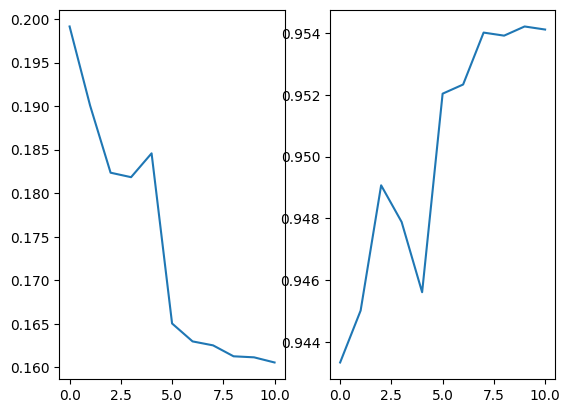

In [446]:
losses=[x["val_loss"] for x in hist]
accs=[x["val_acc"] for x in hist]


fig,ax=plt.subplots(1,2)
ax[0].plot(losses)
ax[1].plot(accs)

### Prediction


In [404]:
def predict(model,images):
    images=images.unsqueeze(0)
    out=model(images)
    _,pred= torch.max(out,dim=1)
    return pred[0]

In [406]:
test_ds=MNIST(root="data/",train=False,transform=transforms.ToTensor())

In [408]:
len(test_ds)
    

10000

tensor(7, device='cuda:0')
7


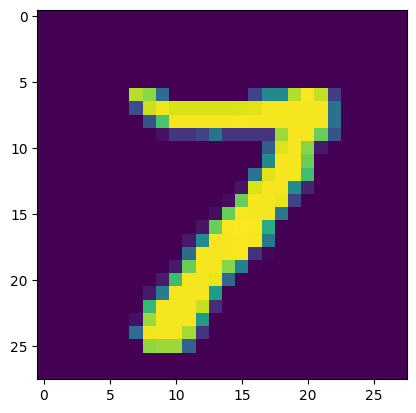

In [410]:
img,label=test_ds[34]
plt.imshow(img.permute(1,2,0))
print(predict(model,to_device(img,device)))
print(label)

In [418]:
test_dl=Device_Data_Loader(DataLoader(test_ds,batch_size=256,num_workers=4,pin_memory=True),device)

In [420]:
evaluate(model,test_dl)

{'val_loss': 0.1775759756565094, 'val_acc': 0.9493163824081421}

Assignment:
feed forward neurl network for cifar10 dataset
-imageclassificationbase(nn.Module) #for genral methods
-mnist_model(imageclassificationbase)